# The Basics: Training Your First Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

%matplotlib inline

## Setup device for training

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda


## Set up training data

As we saw before, supervised Machine Learning is all about figuring out an algorithm given a set of inputs and outputs.
Since the task in this Codelab is to create a model that can give the temperature in Fahrenheit when given the degrees in Celsius, we create two lists `celsius_q` and `fahrenheit_a` that we can use to train our model.

In [3]:
samples = torch.tensor([
    [3, 1], 
    [2, 0], 
    [9, 0], 
    [3, 0], 
    [4, 1],
    [5, 1], 
    [1, 0],
    [3, 1], 
    [7, 1], 
    [0, 0],
    [13, 0]
], dtype=torch.float32)
labels = torch.tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0], dtype=torch.float32)
print(samples)
print(labels)

tensor([[ 3.,  1.],
        [ 2.,  0.],
        [ 9.,  0.],
        [ 3.,  0.],
        [ 4.,  1.],
        [ 5.,  1.],
        [ 1.,  0.],
        [ 3.,  1.],
        [ 7.,  1.],
        [ 0.,  0.],
        [13.,  0.]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.])


In [4]:
for i, c in enumerate(samples):
    print(f'sample: {c} --> label: {labels[i]}')

sample: tensor([3., 1.]) --> label: 1.0
sample: tensor([2., 0.]) --> label: 0.0
sample: tensor([9., 0.]) --> label: 0.0
sample: tensor([3., 0.]) --> label: 0.0
sample: tensor([4., 1.]) --> label: 1.0
sample: tensor([5., 1.]) --> label: 1.0
sample: tensor([1., 0.]) --> label: 0.0
sample: tensor([3., 1.]) --> label: 1.0
sample: tensor([7., 1.]) --> label: 1.0
sample: tensor([0., 0.]) --> label: 0.0
sample: tensor([13.,  0.]) --> label: 0.0


In [10]:
class TempDataset(Dataset):
    """Temperature dataset"""
    
    def __init__(self, samples, labels, transform=None):
        """
        Args:
            celsius_q: a list of temperature in Celsius
            fahrenheit_a: a list of corresponding temperature in Fahrenheit
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.temp_list = list(zip(samples, labels))
        self.transform = transform

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.transform:
            sample = self.transform(self.temp_list[idx])

        return self.temp_list[idx]
    
    def __len__(self):
        return len(self.temp_list)


train_dataset = TempDataset(samples, labels)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
train_dataset.temp_list[0:10]

[(tensor([3., 1.]), tensor(1.)), (tensor([2., 0.]), tensor(0.))]

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(2, 1)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = Net()

# move model to the right device
model.to(device)

Net(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

**Note**

You will often see the layers defined inside the model definition, rather than beforehand:

```python
model = nn.Sequential(
  nn.Linear(1, 1)
)
```

## Compile the model, with loss and optimizer functions

Before training, the model has to be compiled. When compiled for training, the model is given:

- **Loss function** — A way of measuring how far off predictions are from the desired outcome. (The measured difference is called the "loss".)

- **Optimizer function** — A way of adjusting internal values in order to reduce the loss.


In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

These are used during training to first calculate the loss at each point, and then improve it. In fact, the act of calculating the current loss of a model and then improving it is precisely what training is.

During training, the optimizer function is used to calculate adjustments to the model's internal variables. The goal is to adjust the internal variables until the model (which is really a math function) mirrors the actual equation for converting Celsius to Fahrenheit.

PyTorch uses numerical analysis to perform this tuning, and all this complexity is hidden from you so we will not go into the details here. What is useful to know about these parameters are:

The loss function ([mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)) and the optimizer ([Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)) used here are standard for simple models like this one, but many others are available. It is not important to know how these specific functions work at this point.

One part of the Optimizer you may need to think about when building your own models is the learning rate (`0.1` in the code above). This is the step size taken when adjusting values in the model. If the value is too small, it will take too many iterations to train the model. Too large, and accuracy goes down. Finding a good value often involves some trial and error, but the range is usually within 0.001 (default), and 0.1

## Train the model

During training, the model takes in Celsius values, performs a calculation using the current internal variables (called "weights") and outputs values which are meant to be the Fahrenheit equivalent. Since the weights are initially set randomly, the output will not be close to the correct value. The difference between the actual output and the desired output is calculated using the loss function, and the optimizer function directs how the weights should be adjusted.

This cycle of calculate, compare, adjust is controlled by the `loss.backward()` and `optimizer.step()` method. The first argument is the inputs, the second argument is the desired outputs. The `epochs` argument specifies how many times this cycle should be run.

In [7]:
# How many time the model will learn through the dataset
EPOCHS = 1
epoch_list = []
epoch_loss_list = []

for epoch in range(EPOCHS):
    epoch_list.append(epoch)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        print(inputs)
        print(labels)
        break
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.view(-1, 1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # statistics
    epoch_loss = running_loss / len(train_dataset)
    epoch_loss_list.append(epoch_loss)
    
    if epoch % 50 == 49:    
        print(f'Epoch: {epoch+1} Loss: {epoch_loss}')

print('Finished Training')

tensor([[3., 1.],
        [3., 0.]])
tensor([1., 0.])
Finished Training


In later sessions, we will go into more details on what actually happens here and how a Dense layer actually works internally.

## Display training statistics

We will plot how the loss of our model goes down after each training epoch. A high loss means that the Fahrenheit degrees the model predicts is far from the corresponding value in `fahrenheit_a`.

We'll use [Matplotlib](https://matplotlib.org/) to visualize this (you could use another tool). As you can see, our model improves very quickly at first, and then has a steady, slow improvement until it is very near "perfect" towards the end.

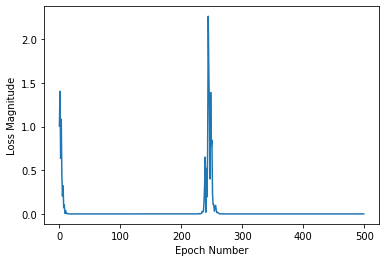

In [9]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(epoch_list, epoch_loss_list)

## Use the model to predict values

Now you have a model that has been trained to learn the relationship between `celsius_q` and `fahrenheit_a`. You can use the predict method to have it calculate the Fahrenheit degrees for a previously unknown Celsius degrees.

So, for example, if the Celsius value is 100, what do you think the Fahrenheit result will be? Take a guess before you run this code.

In [10]:
with torch.no_grad():
    sample = torch.tensor([[100.0, 50.]]).to(device)
    result = model(sample)
    print(result)

tensor([[50.]], device='cuda:0')


The correct answer is $100 \times 1.8 + 32 = 212$, so our model is doing really well.

### To review


*   We created a model with a Dense layer
*   We trained it with 3500 examples (7 pairs, over 500 epochs).

Our model tuned the variables (weights) in the Dense layer until it was able to return the correct Fahrenheit value for any Celsius value. (Remember, 100 Celsius was not part of our training data.)

## Looking at the layer weights

Finally, let's print the internal variables of the Dense layer. 

In [11]:
print(f'These are the layer variables: {list(model.parameters())}')

These are the layer variables: [Parameter containing:
tensor([[2.9094e-19, 1.0000e+00]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.6300e-18], device='cuda:0', requires_grad=True)]


The first variable is close to ~1.8 and the second to ~32. These values (1.8 and 32) are the actual variables in the real conversion formula.

This is really close to the values in the conversion formula. We'll explain this in an upcoming video where we show how a Dense layer works, but for a single neuron with a single input and a single output, the internal math looks the same as [the equation for a line](https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form), $y = mx + b$, which has the same form as the conversion equation, $f = 1.8c + 32$.

Since the form is the same, the variables should converge on the standard values of 1.8 and 32, which is exactly what happened.

With additional neurons, additional inputs, and additional outputs, the formula becomes much more complex, but the idea is the same.

### A little experiment

Just for fun, what if we created more Dense layers with different units, which therefore also has more variables?

In [11]:
model = nn.Sequential(
    nn.Linear(1, 4),
    nn.Linear(4, 2),
    nn.Linear(2, 1)
)

## YOUR CODE HERE

## YOUR CODE HERE

As you can see, this model is also able to predict the corresponding Fahrenheit value really well. But when you look at the variables (weights) in the `l0` and `l1` layers, they are nothing even close to ~1.8 and ~32. The added complexity hides the "simple" form of the conversion equation.

Stay tuned for the upcoming video on how Dense layers work for the explanation.